<a href="https://colab.research.google.com/github/Raafat-Nagy/Deep-Learning-Projects/blob/main/Oral_Diseases_Classification_Project/Oral_Diseases_Classification_using_ResNet50V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oral Diseases Classification using ResNet50V2

---

## Project Overview:

This project focuses on the classification of oral diseases using a deep learning model based on a pre-trained ResNet50V2 architecture. The primary objective is to build an image classification model that can accurately predict different types of oral diseases from a dataset of images.

#### Key Steps:
1. **Data Collection**: The dataset is sourced directly from Kaggle, specifically the "Oral Diseases" dataset, which contains images of various oral conditions such as calculus, caries, gingivitis, ulcers, tooth discoloration, and hypodontia.

   
2. **Data Preprocessing and Augmentation**: The dataset is divided into training, validation, and testing sets. Data augmentation techniques such as random rotation, horizontal flip, and zoom are applied to the training set to generate diverse variations of the images and improve the model's robustness.

3. **Model Architecture**: A pre-trained ResNet50V2 model is used as the base model, and fine-tuning is performed on the last few layers. A custom classification head is added to the network, consisting of a global average pooling layer followed by fully connected (dense) layers.

4. **Model Training**: The model is trained using the Adam optimizer and sparse categorical cross-entropy loss. Callbacks like `EarlyStopping` and `ReduceLROnPlateau` are implemented to prevent overfitting and optimize training by adjusting the learning rate when necessary.

5. **Model Evaluation**: After training, the model is evaluated on the test set, and performance metrics such as accuracy, loss, and confusion matrix are calculated to assess the model’s effectiveness in classifying oral diseases.

6. **Model Saving**: The trained model is saved for future use and deployment.

#### Technologies Used:
- **TensorFlow** and **Keras** for model building and training.
- **ResNet50V2** for transfer learning.
- **Matplotlib** and **Seaborn** for data visualization.

This project demonstrates how deep learning can be applied to medical image classification tasks, particularly for detecting and diagnosing oral diseases from images.

---

## Import Libraries

In [1]:
import tensorflow as tf

print(tf.__version__)

2.18.0


In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
!wget -O "dl_utils.py" "https://raw.githubusercontent.com/Raafat-Nagy/Deep-Learning-Projects/refs/heads/main/dl_utils/dl_utils.py"

--2025-04-27 04:07:34--  https://raw.githubusercontent.com/Raafat-Nagy/Deep-Learning-Projects/refs/heads/main/dl_utils/dl_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8996 (8.8K) [text/plain]
Saving to: ‘dl_utils.py’

dl_utils.py         100%[===================>]   8.79K  --.-KB/s    in 0s      

2025-04-27 04:07:34 (74.3 MB/s) - ‘dl_utils.py’ saved [8996/8996]



---

## Download Dataset from Kaggle

In [4]:
from dl_utils import download_kaggle_data

download_kaggle_data('salmansajid05/oral-diseases',setup_kaggle_api=True)

Please upload your 'kaggle.json' file:


Saving kaggle.json to kaggle.json
✅ Kaggle API is configured successfully!
✅ Successfully downloaded and extracted: oral-diseases


---

## Split Dataset into (Train, Val, Test)

In [5]:
from dl_utils import split_class

In [6]:
# Define original dataset directories
original_dirs = {
    "Calculus": "/content/oral-diseases/Calculus/Calculus",
    "Caries": "/content/oral-diseases/Data caries/Data caries/caries augmented data set/preview",
    "Gingivitis": "/content/oral-diseases/Gingivitis/Gingivitis",
    "Ulcers": "/content/oral-diseases/Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview",
    "Tooth-Discoloration": "/content/oral-diseases/Tooth Discoloration/Tooth Discoloration /Tooth_discoloration_augmented_dataser/preview",
    "Hypodontia": "/content/oral-diseases/hypodontia/hypodontia",
}

In [7]:
new_dataset_dir = "/content/oral-diseases-new"

summary = []
for class_name, class_dir in original_dirs.items():
    class_details = split_class(
        class_dir,
        output_dir=new_dataset_dir,
        ratio=(0.7, 0.2, 0.1),
        class_name=class_name,
        seed=42,
    )
    summary.append(class_details)

Processing class 'Calculus' - Total images: 1296
  Train images: 907
  Val   images: 259
  Test  images: 130

Processing class 'Caries' - Total images: 2382
  Train images: 1667
  Val   images: 476
  Test  images: 239

Processing class 'Gingivitis' - Total images: 2349
  Train images: 1644
  Val   images: 469
  Test  images: 236

Processing class 'Ulcers' - Total images: 2541
  Train images: 1778
  Val   images: 508
  Test  images: 255

Processing class 'Tooth-Discoloration' - Total images: 1834
  Train images: 1283
  Val   images: 366
  Test  images: 185

Processing class 'Hypodontia' - Total images: 1251
  Train images: 875
  Val   images: 250
  Test  images: 126



In [8]:
!rm -rf /content/oral-diseases

In [9]:
data_summary = pd.DataFrame(summary)
data_summary

class  total  train  val  test
0             Calculus   1296    907  259   130
1               Caries   2382   1667  476   239
2           Gingivitis   2349   1644  469   236
3               Ulcers   2541   1778  508   255
4  Tooth-Discoloration   1834   1283  366   185
5           Hypodontia   1251    875  250   126

---

## Visualize Data Distribution

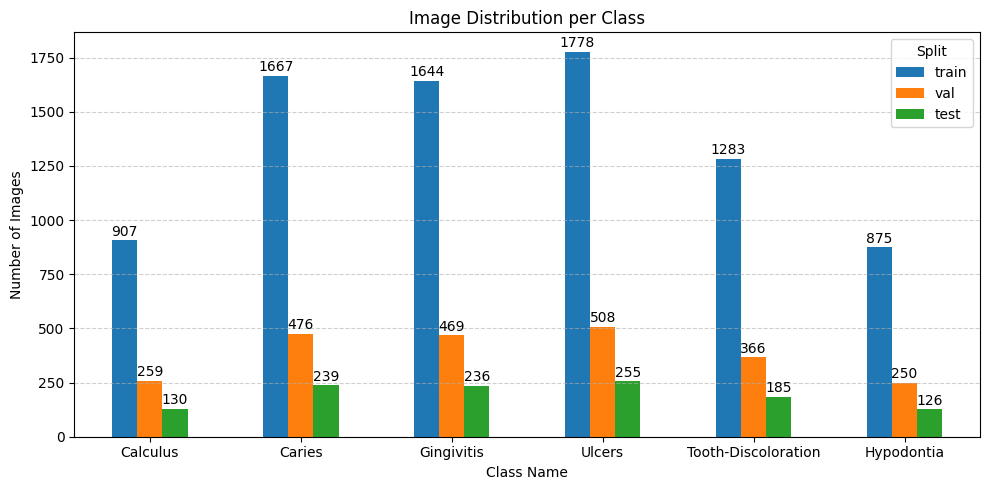

In [10]:
ax = data_summary.plot(
    x="class", y=["train", "val", "test"], kind="bar", figsize=(10, 5)
)

plt.title("Image Distribution per Class")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Split")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 20, str(int(height)), ha="center")

plt.tight_layout()
plt.show()

In [11]:
class_names = data_summary["class"].values.tolist()
total_images = data_summary["total"].sum()
class_count = len(data_summary)

print("Class-Names:\n", class_names)
print("Class-Count:", class_count)
print("Total-Images:", total_images)

Class-Names:
 ['Calculus', 'Caries', 'Gingivitis', 'Ulcers', 'Tooth-Discoloration', 'Hypodontia']
Class-Count: 6
Total-Images: 11653


---

## Load Data

In [12]:
train_dir = os.path.join(new_dataset_dir, "train")
val_dir = os.path.join(new_dataset_dir, "val")
test_dir = os.path.join(new_dataset_dir, "test")

In [13]:
# Define parameters
batch_size = 64
img_height = 256
img_width = 256
seed = 42


# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

Found 8154 files belonging to 6 classes.
Found 2328 files belonging to 6 classes.
Found 1171 files belonging to 6 classes.


In [14]:
class_names = train_ds.class_names
print(class_names)

['Calculus', 'Caries', 'Gingivitis', 'Hypodontia', 'Tooth-Discoloration', 'Ulcers']


In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 256, 256, 3)
(64,)


---

## Visualize Random Images

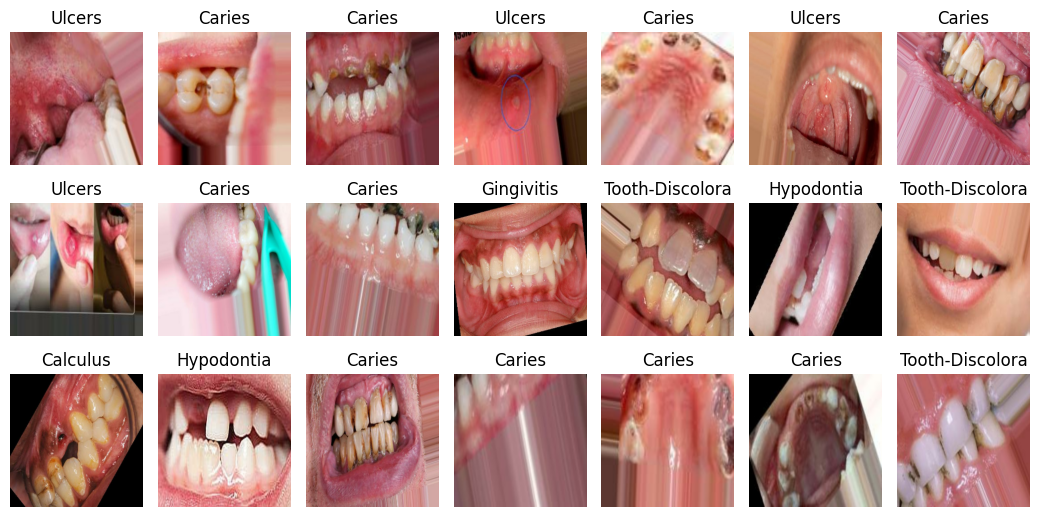

In [16]:
def plot_random_images(data, rows=3, cols=7, max_label_chars=15):
    """rows * cols must be less than or equal to the number of Batch samples (batch_size)."""

    plt.figure(figsize=(cols * 1.5, rows * 1.8))
    for images, labels in data.take(1):
        for i in range(rows * cols):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]][:max_label_chars])
            plt.axis("off")
        plt.tight_layout()
        plt.show()


plot_random_images(train_ds)

---

## Data Augmentation

In [17]:
data_augmentation = tf.keras.Sequential(
    [
        # tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomZoom(0.2),
    ]
)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

### Visualize augmented images

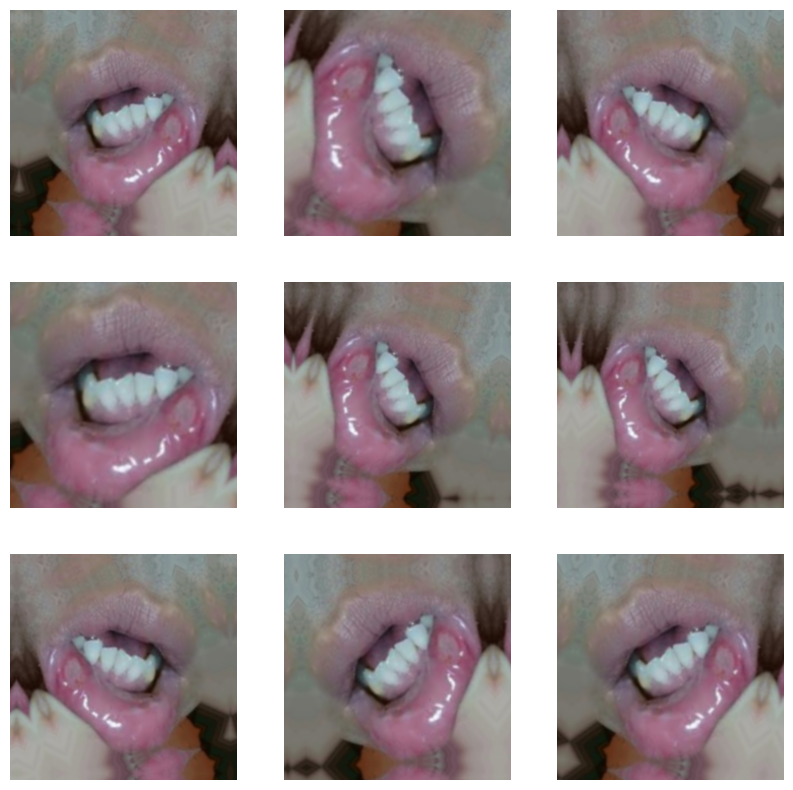

In [34]:
def plot_augmented_image(data):
    for image, _ in data.take(1):
        plt.figure(figsize=(10, 10))
        first_image = image[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
            plt.imshow(augmented_image[0] / 255)
            plt.axis("off")
    plt.show()


plot_augmented_image(train_ds)

---

## Build the Model

### Load Pre-trained Base Model

In [44]:
from tensorflow.keras.applications import ResNet50V2

input_shape = (img_height, img_width, 3)
base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=input_shape)

In [45]:
print("output_names:", base_model.output_names[0])
print("output_shape:", base_model.output_shape)

output_names: post_relu
output_shape: (None, 8, 8, 2048)


### Fine-tuning

In [46]:
print("Number of Trainable_Variables:", len(base_model.trainable_variables))

Number of Trainable_Variables: 172


In [47]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  190


In [50]:
base_model.trainable = True

fine_tune_at = 175
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [51]:
len(base_model.trainable_variables)

14

In [52]:
base_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 64, 64,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 64, 64,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 66, 66,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 64, 64,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 5,519,360 (21.05 MB)

 Non-trainable params: 18,045,440 (68.84 MB)

### Create Full Model

In [54]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import preprocess_input


def build_model(base_model, input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    return Model(inputs, outputs)


model = build_model(base_model, input_shape, len(class_names))

In [55]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 8, 8, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,827,846 (90.90 MB)

 Trainable params: 5,782,406 (22.06 MB)

 Non-trainable params: 18,045,440 (68.84 MB)

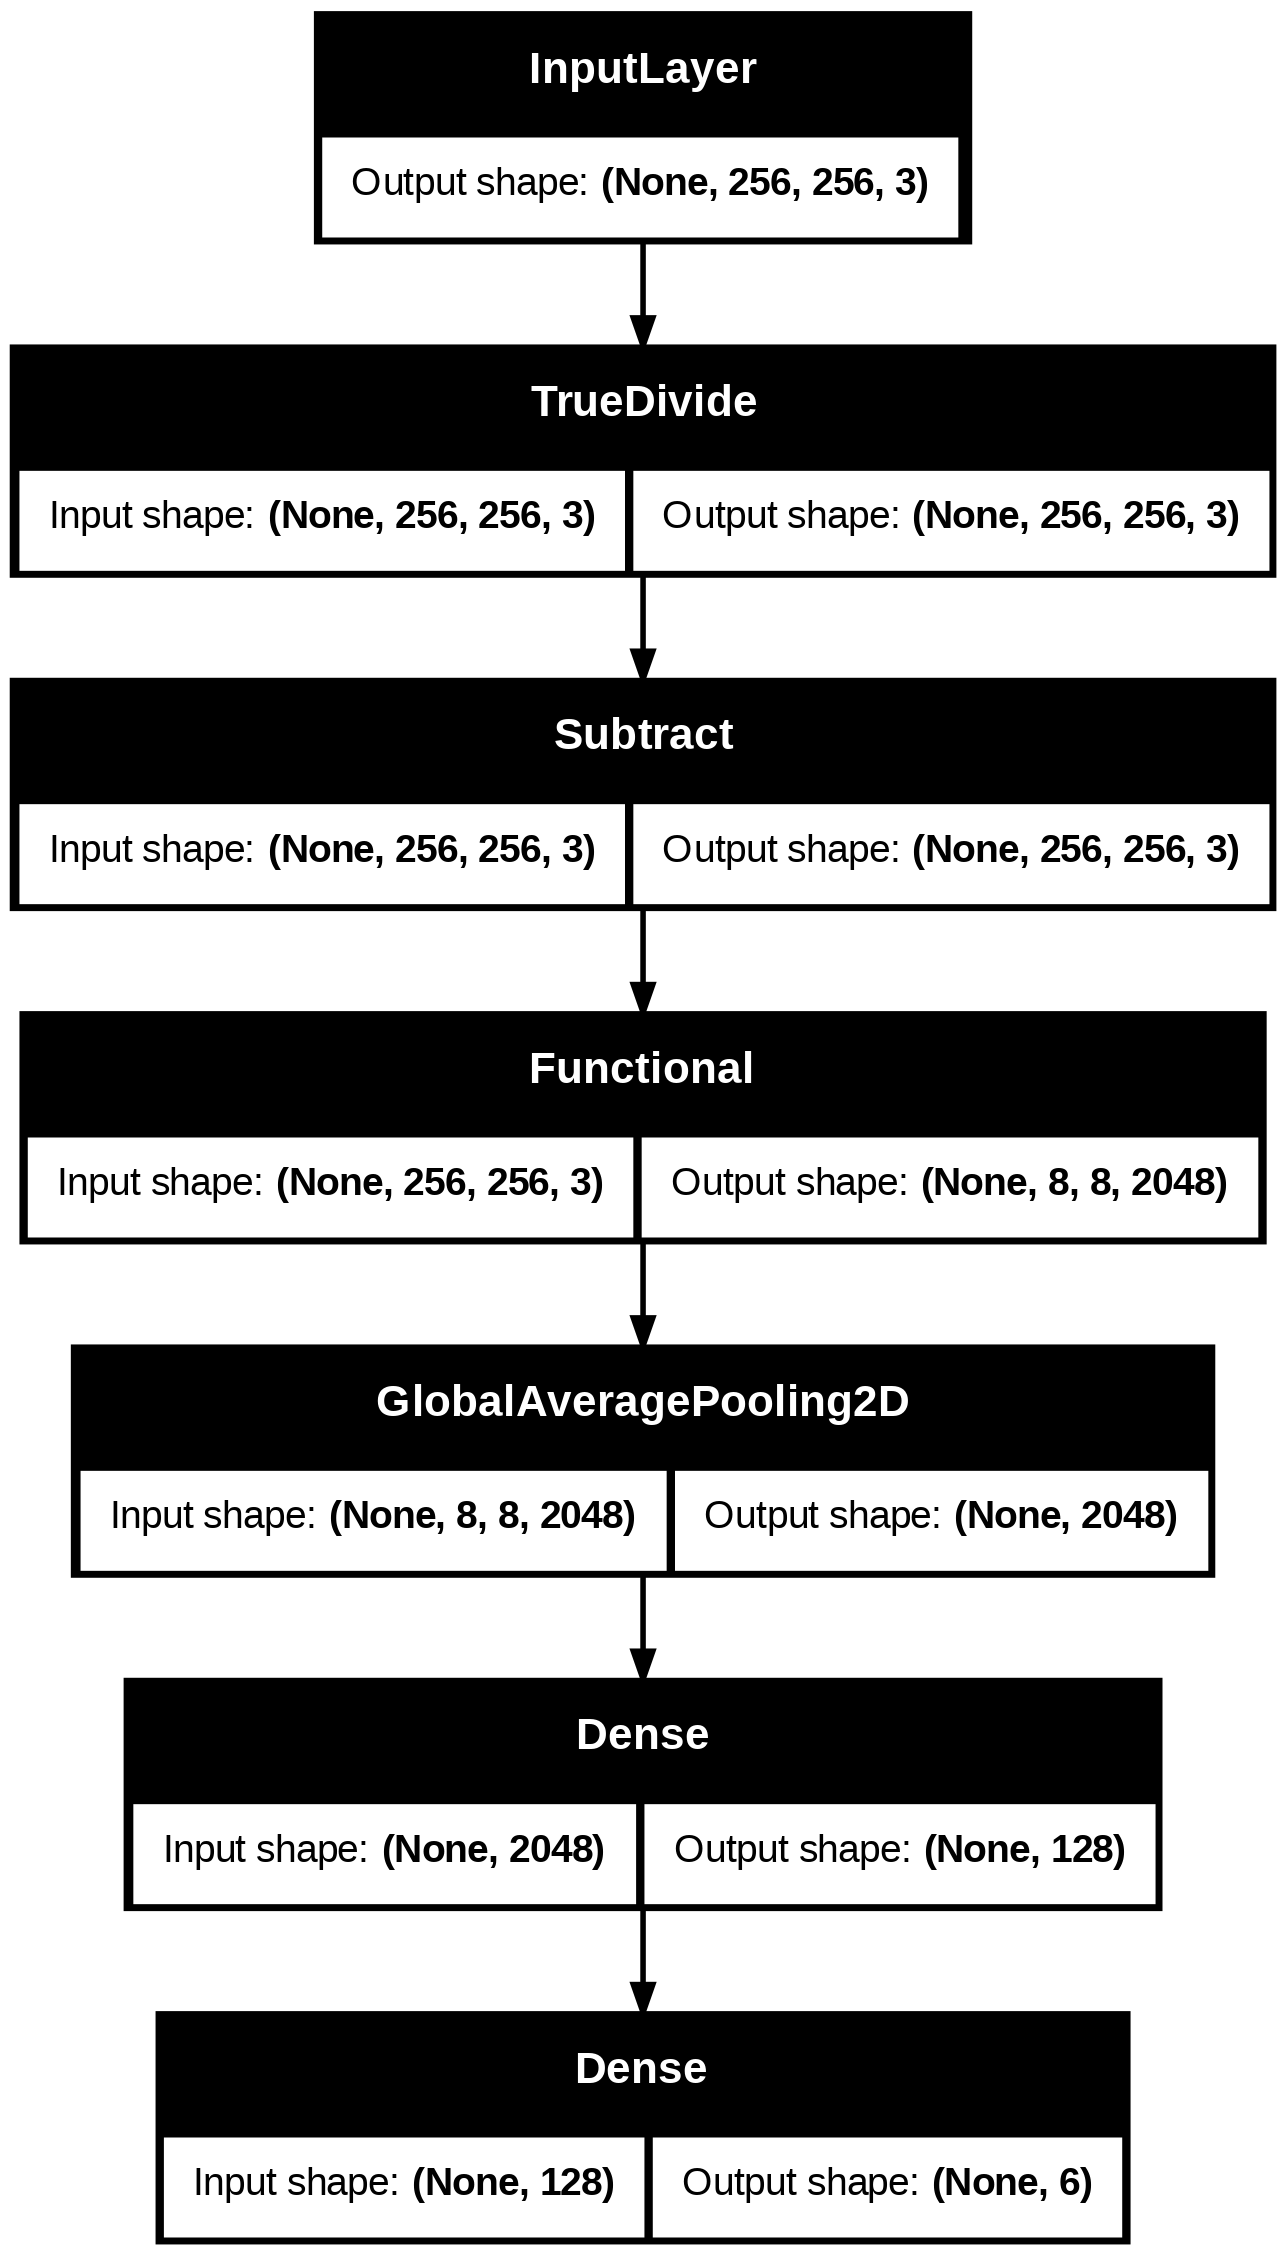

In [56]:
tf.keras.utils.plot_model(model, show_shapes=True)

---

## Compile the Model

In [57]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = ["accuracy"]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

---

## Train the Model

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

In [59]:
initial_epochs = 15
history = model.fit(
    train_ds, validation_data=val_ds, epochs=initial_epochs, callbacks=callbacks
)

Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.6950 - loss: 0.7808 - val_accuracy: 0.8398 - val_loss: 0.5698 - learning_rate: 0.0010
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.8519 - loss: 0.3722 - val_accuracy: 0.8793 - val_loss: 0.3383 - learning_rate: 0.0010
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8992 - loss: 0.2508 - val_accuracy: 0.8973 - val_loss: 0.2482 - learning_rate: 0.0010
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8953 - loss: 0.2555 - val_accuracy: 0.8991 - val_loss: 0.2117 - learning_rate: 0.0010
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9068 - loss: 0.2102 - val_accuracy: 0.9175 - val_loss: 0.1971 - learning_rate: 0.0010
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9150 - loss: 0.1956 - val_accuracy: 0.8969 - val_loss: 0.2535 - learning_rate: 0.0010
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9116 - loss: 0.

---

## Plot Training History


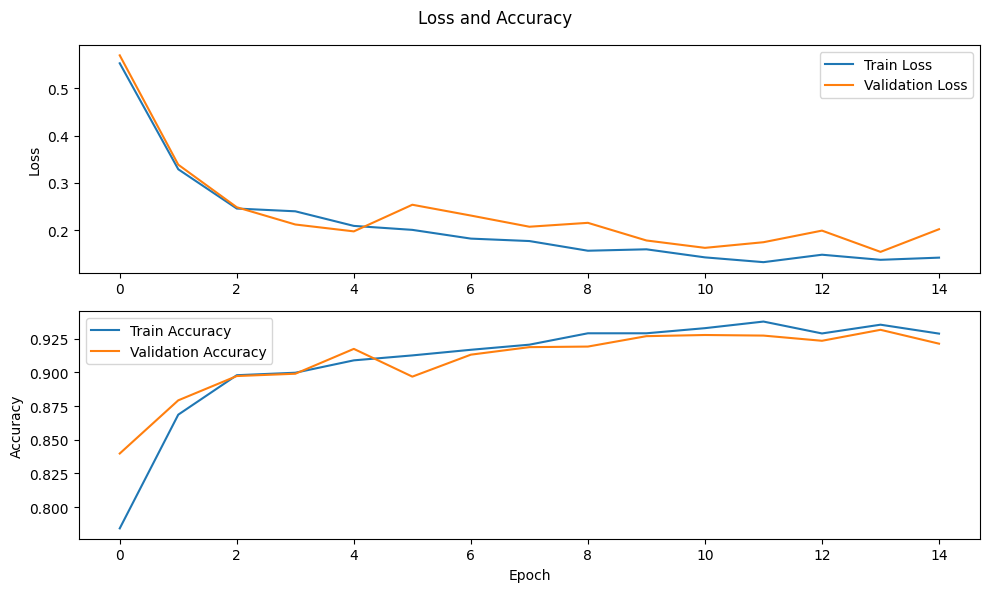

In [70]:
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.suptitle("Loss and Accuracy")

    # Loss plot
    plt.subplot(2, 1, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(2, 1, 2)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.xlabel("Epoch")
    plt.tight_layout()
    plt.show()


plot_training_history(history)

---

## Evaluate the Model

In [71]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.8659 - loss: 0.2759
Test Loss: 0.1731
Test Accuracy: 92.74%


---

## Get true and predicted labels

In [72]:
true_labels = np.concatenate([labels.numpy() for _, labels in test_ds])

true_labels, true_labels.shape

(array([0, 0, 0, ..., 5, 5, 5], dtype=int32), (1171,))

In [73]:
predictions = model.predict(test_ds)
pred_labels = np.argmax(predictions, axis=1)

pred_labels, pred_labels.shape

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step


(array([0, 0, 0, ..., 5, 5, 5]), (1171,))

---

## Classification Report

In [74]:
from sklearn.metrics import classification_report

In [75]:
print(classification_report(true_labels, pred_labels, target_names=class_names))

                     precision    recall  f1-score   support

           Calculus       0.79      0.67      0.72       130
             Caries       0.96      1.00      0.98       239
         Gingivitis       0.83      0.92      0.87       236
         Hypodontia       0.98      0.94      0.96       126
Tooth-Discoloration       0.99      0.95      0.97       185
             Ulcers       0.98      0.98      0.98       255

           accuracy                           0.93      1171
          macro avg       0.92      0.91      0.91      1171
       weighted avg       0.93      0.93      0.93      1171



---

## Confusion Matrix

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

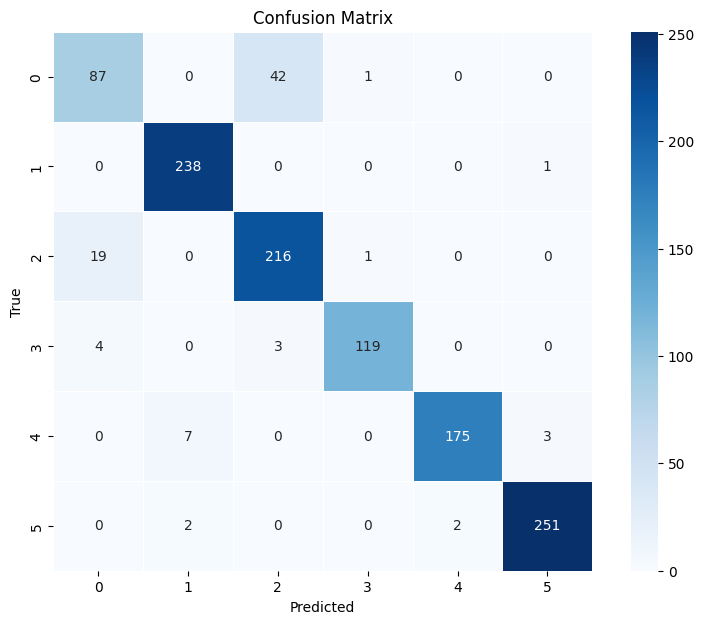

In [77]:
def plot_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, square=True)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


plot_confusion_matrix(true_labels, pred_labels)

---

## Visualize Predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


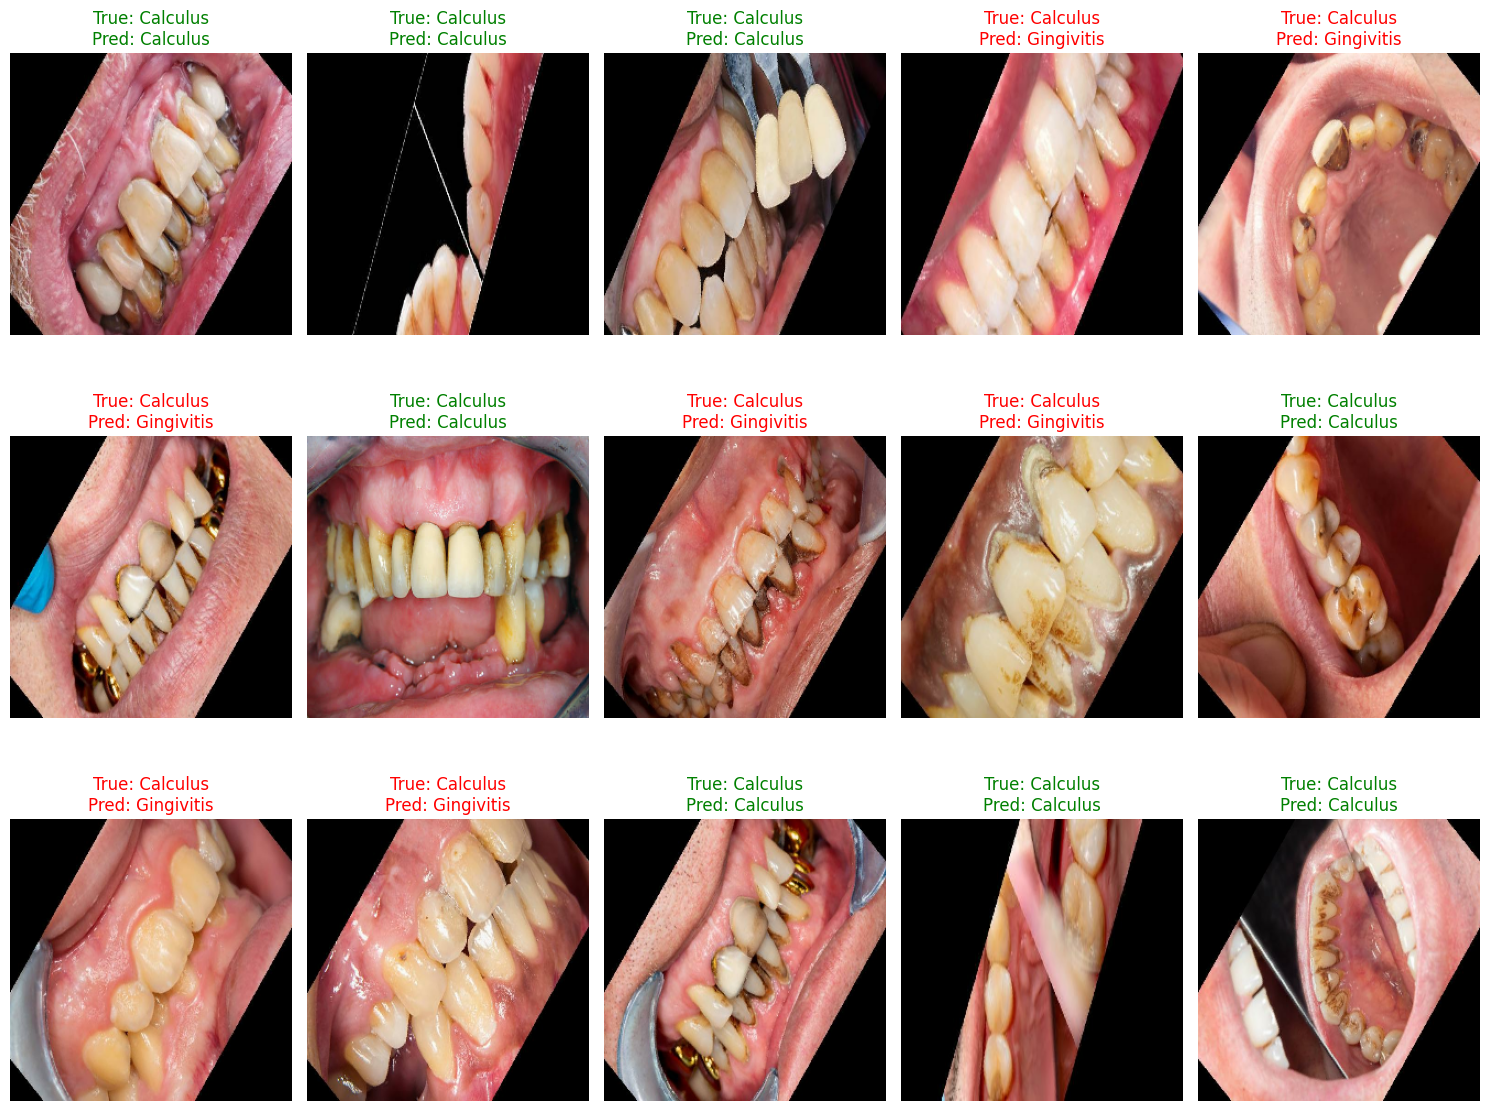

In [83]:
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(15, 12))

    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        predicted_label = class_names[pred_labels[i]]
        color = "green" if true_label == predicted_label else "red"

        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

---

## Save the Model

In [86]:
model.save("Oral_Diseases_Classification_model.keras")
print("Model Saved Successfully!")

Model Saved Successfully!


---
---

## Download Trained Model From Kaggle

In [30]:
!wget -q -O "dl_utils.py" "https://raw.githubusercontent.com/Raafat-Nagy/Deep-Learning-Projects/refs/heads/main/dl_utils/dl_utils.py"

In [12]:
from dl_utils import setup_kaggle

setup_kaggle()

Please upload your 'kaggle.json' file:


Saving kaggle.json to kaggle.json
✅ Kaggle API is configured successfully!


In [13]:
!kaggle kernels output raafatnagy/oral-diseases-classification-using-resnet50v2 -p /content

Output file downloaded to /content/Oral_Diseases_Classification_model.keras
Output file downloaded to /content/__pycache__/dl_utils.cpython-311.pyc
dl_utils.py: Skipping, found more recently modified local copy (use --force to force download)
Output file downloaded to /content/model.png
Kernel log downloaded to /content/oral-diseases-classification-using-resnet50v2.log 


## Predicting a Single Image Using the Trained Model

In [104]:
class_names = test_ds.class_names
print(class_names)

['Calculus', 'Caries', 'Gingivitis', 'Hypodontia', 'Tooth-Discoloration', 'Ulcers']


In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model('Oral_Diseases_Classification_model.keras')

# Class names corresponding to the categories
class_names = ['Calculus', 'Caries', 'Gingivitis', 'Hypodontia', 'Tooth-Discoloration', 'Ulcers']

# Function to load and preprocess an image for prediction
def preprocess_image(image_path, target_size=(256, 256)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    # img_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)  # Preprocess for ResNet50V2
    return img_array

# Function to predict the class of an image
def predict_image(image_path):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    predicted_prob = np.max(predictions)

    return predicted_class, predicted_prob

# Function to display the image and prediction result
def display_image_and_prediction(image_path):
    # Load and display the image
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Get prediction
    predicted_class, predicted_prob = predict_image(image_path)

    # Display prediction result
    print(f"Predicted Class: {predicted_class}")
    print(f"Prediction Probability: {predicted_prob:.4f}")

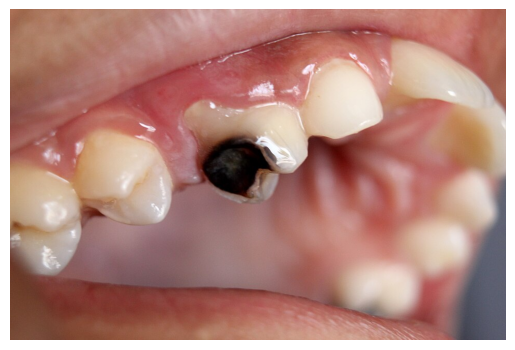

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: Caries
Prediction Probability: 0.9995


In [29]:
# Test with an example image
!wget -q -O "Oral-Diseases.jpg" "https://upload.wikimedia.org/wikipedia/commons/thumb/2/2f/Dental_Caries_Cavity_2.JPG/960px-Dental_Caries_Cavity_2.JPG"
image_path = 'Oral-Diseases.jpg'

display_image_and_prediction(image_path)

---